In [1]:
%matplotlib inline

# ¿Que es torch.nn realmente?

PyTorch proporciona los módulos y clases elegantemente diseñados [``torch.nn``](https://pytorch.org/docs/stable/nn.html), [``torch.optim``](https://pytorch.org/docs/stable/optim.html), [``Dataset``](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) y [``DataLoader``](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) para ayudarlo a crear y entrenar redes neuronales. Para utilizar completamente su poder y personalizarlos para su problema, debe comprender realmente exactamente lo que están haciendo. Para desarrollar esta comprensión, primero entrenaremos la red neuronal básica en el conjunto de datos MNIST sin utilizar ninguna característica de estos modelos; Inicialmente, solo usaremos la funcionalidad de tensor de PyTorch más básica. A continuación, vamos a añadir de forma incremental una característica de ``torch.nn``, ``torch.optim``, ``Dataset``, o ``DataLoader`` en un momento, mostrando exactamente lo que hace cada pieza, y cómo funciona para que el código sea más concisa, o más flexible.

## Configuración de datos MNIST

Usaremos el conjunto de datos clásico [MNIST](http://deeplearning.net/data/mnist), que consiste en imágenes en blanco y negro de dígitos dibujados a mano (entre 0 y 9).

Usaremos [``pathlib``](https://docs.python.org/3/library/pathlib.html) para tratar con rutas (parte de la biblioteca estándar de Python 3) y descargaremos el conjunto de datos mediante [solicitudes](http://docs.python-requests.org/en/master). Solo importaremos módulos cuando los usemos, para que pueda ver exactamente lo que se está usando en cada punto.

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Este conjunto de datos está en formato de matriz de numpy y se ha almacenado usando pickle, un formato específico de Python para serializar datos.

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Cada imagen mide 28 x 28 y se almacena como una fila plana de 784 de longitud (= 28x28). Echemos un vistazo a uno; primero tenemos que remodelarlo a 2d.

(50000, 784)


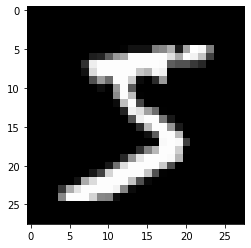

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch usa ``torch.tensor``, en lugar de matrices numpy, por lo que necesitamos convertir nuestros datos.

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Red neuronal desde cero (sin torch.nn)

Primero creemos un modelo usando nada más que operaciones de tensor de PyTorch.

PyTorch proporciona métodos para crear tensores llenos de cero o aleatorios, que usaremos para crear nuestros pesos y sesgos para un modelo lineal simple. Estos son solo tensores regulares, con una adición muy especial: le decimos a PyTorch que requieren un gradiente. Esto hace que PyTorch registre todas las operaciones realizadas en el tensor, de modo que pueda calcular el gradiente durante la retropropagación automáticamente.

Para los pesos, los configuramos ``requires_grad`` **después** de la inicialización, ya que no queremos que ese paso se incluya en el gradiente. (Tenga en cuenta que un final _ en PyTorch significa que la operación se realiza en el lugar).

 > **Nota**: Estamos inicializando los pesos aquí con la [inicialización de Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (multiplicando por 1/sqrt(n)).

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Gracias a la capacidad de PyTorch para calcular gradientes automáticamente, podemos usar cualquier función estándar de Python (u objeto invocable) como modelo. Así que escribamos una multiplicación de matriz simple y una suma transmitida para crear un modelo lineal simple. También necesitamos una función de activación, así que escribiremos ``log_softmax`` y la usaremos. Recuerde: aunque PyTorch proporciona muchas funciones de pérdida preescritas, funciones de activación, etc., puede escribir fácilmente las suyas propias usando Python simple. PyTorch incluso creará código de GPU rápido o de CPU vectorizado para su función automáticamente.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

En lo anterior, ``@`` representa la operación del producto escalar. Llamaremos a nuestra función en un lote de datos (en este caso, 64 imágenes). Este es un *forward pass*. Tenga en cuenta que nuestras predicciones no serán mejores que las aleatorias en esta etapa, ya que comenzamos con pesos aleatorios.

In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.1300, -2.5687, -2.5093, -2.0284, -2.3642, -1.9145, -2.3055, -2.7405,
        -2.5479, -2.2283], grad_fn=<SelectBackward>) torch.Size([64, 10])


Como puede ver, el tensor ``preds`` contiene no solo los valores del tensor, sino también una función de gradiente. Usaremos esto más tarde para hacer backprop.

Implementemos una probabilidad de registro negativa para usarla como función de pérdida (nuevamente, podemos usar Python estándar):

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Comprobemos nuestra pérdida con nuestro modelo aleatorio, para que podamos ver si mejoramos después de un pase de backprop más tarde.

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2503, grad_fn=<NegBackward>)


Implementemos también una función para calcular la precisión de nuestro modelo. Para cada predicción, si el índice con el valor más grande coincide con el valor objetivo, entonces la predicción fue correcta.

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Comprobemos la precisión de nuestro modelo aleatorio, para que podamos ver si nuestra precisión mejora a medida que mejora nuestra pérdida.

In [12]:
print(accuracy(preds, yb))

tensor(0.0938)


Ahora podemos ejecutar un ciclo de entrenamiento. Para cada iteración, haremos lo siguiente:

 * seleccione un mini-lote de datos (de tamaño ``bs``)
 * usar el modelo para hacer predicciones
 * calcular la perdida
 * loss.backward() actualiza los gradientes del modelo, en este caso, ``weights`` y ``bias``.


Ahora usamos estos gradientes para actualizar los ``weights`` y ``bias``. Hacemos esto dentro del administrador de contexto ``torch.no_grad()``, porque no queremos que estas acciones se registren para nuestro próximo cálculo del gradiente. Puede leer más sobre cómo PyTorch's Autograd registra las operaciones [aquí](https://pytorch.org/docs/stable/notes/autograd.html).

Luego, establecemos los gradientes en cero, de modo que estemos listos para el siguiente ciclo. De lo contrario, nuestros gradientes registrarían un recuento de todas las operaciones que habían sucedido (es decir, ``loss.backward()`` agregarían los gradientes a lo que ya esté almacenado, en lugar de reemplazarlos).

 > **Tip**:
 > Puede usar el depurador de Python estándar para recorrer el código PyTorch, lo que le permite verificar los distintos valores de las variables en cada paso. Descomenta ``set_trace()`` a continuación para probarlo.

In [13]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

Eso es todo: hemos creado y entrenado una red neuronal mínima (en este caso, una regresión logística, ya que no tenemos capas ocultas) ¡completamente desde cero!

Comprobemos la pérdida y la precisión y comparémoslas con lo que obtuvimos antes. Esperamos que la pérdida haya disminuido y la precisión haya aumentado, y lo han hecho.

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0804, grad_fn=<NegBackward>) tensor(1.)


## Usando torch.nn

Ahora refactorizaremos nuestro código, para que haga lo mismo que antes, solo que comenzaremos a aprovechar las clases de PyTorch ``nn`` para hacerlo más conciso y flexible. En cada paso a partir de aquí, deberíamos hacer nuestro código uno o más de: más corto, más comprensible y/o más flexible.

El primer paso y el más fácil es acortar nuestro código reemplazando nuestras funciones de activación y pérdida escritas a mano por las de ``torch.nn.functional`` (que generalmente se importa al espacio de nombres ``F`` por convención). Este módulo contiene todas las funciones de la biblioteca ``torch.nn`` (mientras que otras partes de la biblioteca contienen clases). Además de una amplia gama de funciones de pérdida y activación, también encontrará aquí algunas funciones convenientes para crear redes neuronales, como las funciones de agrupación. (También hay funciones para hacer convoluciones, capas lineales, etc., pero como veremos, generalmente se manejan mejor usando otras partes de la biblioteca).

Si está utilizando una pérdida de probabilidad de registro negativa y una activación de softmax de registro, entonces Pytorch proporciona una única función ``F.cross_entropy`` que combina los dos. Así que incluso podemos eliminar la función de activación de nuestro modelo.

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Tenga en cuenta que ya no llamamos a ``log_softmax`` en la función model. Confirmemos que nuestra pérdida y precisión son las mismas que antes:

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0804, grad_fn=<NllLossBackward>) tensor(1.)


## Refactorizar usando nn.Module

A continuación, usaremos ``nn.Module`` y ``nn.Parameter``, para un ciclo de entrenamiento más claro y conciso. Hacemos una subclase ``nn.Module`` (que en sí misma es una clase y es capaz de realizar un seguimiento del estado). En este caso, queremos crear una clase que contenga nuestros pesos, sesgo y método para el forward step. ``nn.Module`` tiene una serie de atributos y métodos (como ``.parameters()`` y ``.zero_grad()``) que usaremos.

 > **Nota**:
 > ``nn.Module`` (M mayúscula) es un concepto específico de PyTorch, y es una clase que usaremos mucho. ``nn.Module`` no debe confundirse con el concepto de Python de un [module](https://docs.python.org/3/tutorial/modules.html) (en minúsculas m) , que es un archivo de código Python que se puede importar.

In [17]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Dado que ahora estamos usando un objeto en lugar de solo usar una función, primero tenemos que crear una instancia de nuestro modelo:

In [18]:
model = Mnist_Logistic()

Ahora podemos calcular la pérdida de la misma forma que antes. Tenga en cuenta que los objetos ``nn.Module`` se utilizan como si fueran funciones (es decir, son *invocables*), pero detrás de escena Pytorch llamará a nuestro método ``forward`` automáticamente.

In [19]:
print(loss_func(model(xb), yb))

tensor(2.3902, grad_fn=<NllLossBackward>)


Anteriormente, para nuestro ciclo de entrenamiento, teníamos que actualizar los valores para cada parámetro por nombre y poner a cero manualmente los grados de cada parámetro por separado, así:

```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

Ahora podemos aprovechar ``model.parameters()`` y ``model.zero_grad()`` (ambos definidos por PyTorch para ``nn.Module``) para hacer esos pasos más concisos y menos propensos al error de olvidar algunos de nuestros parámetros, particularmente si tuviéramos un modelo más complicado:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

Envolveremos nuestro pequeño ciclo de entrenamiento en una función ``fit`` para que podamos ejecutarlo de nuevo más tarde.

In [20]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Comprobemos dos veces que nuestra pérdida ha disminuido:

In [21]:
print(loss_func(model(xb), yb))

tensor(0.0810, grad_fn=<NllLossBackward>)


## Refactorizar usando nn.Lineal

Seguimos refactorizando nuestro código. En lugar de definir e inicializar manualmente ``self.weights`` y ``self.bias``, y calcular ``xb@self.weights + self.bias``, usaremos la clase [``nn.Linear``](https://pytorch.org/docs/stable/nn.html#linear-layers) de Pytorch para una capa lineal, que hace todo eso por nosotros. Pytorch tiene muchos tipos de capas predefinidas que pueden simplificar enormemente nuestro código y, a menudo, también lo hacen más rápido

In [22]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

Instanciamos nuestro modelo y calculamos la pérdida de la misma manera que antes:

In [23]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3977, grad_fn=<NllLossBackward>)


Todavía podemos usar nuestro mismo método ``fit`` igual que antes.

In [24]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward>)


## Refactorizar usando optim

Pytorch también tiene un paquete con varios algoritmos de optimización, ``torch.optim``. Podemos usar el método ``step`` de nuestro optimizador para dar un paso adelante, en lugar de actualizar manualmente cada parámetro.

Esto nos permitirá reemplazar nuestro anterior paso de optimización codificado manualmente:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

y en su lugar use solo:

```python
opt.step()
opt.zero_grad()
```

(``optim.zero_grad()`` restablece el gradiente a 0 y debemos llamarlo antes de calcular el gradiente para el siguiente minibatch).

In [25]:
from torch import optim

Definiremos una pequeña función para crear nuestro modelo y optimizador para que podamos reutilizarlo en el futuro.

In [26]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2935, grad_fn=<NllLossBackward>)
tensor(0.0832, grad_fn=<NllLossBackward>)


Refactor using Dataset
------------------------------

PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.
`This tutorial <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`_
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_
is a Dataset wrapping tensors. By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor. This will make it easier to access both the
independent and dependent variables in the same line as we train.



In [ ]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [ ]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
::
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


Now, we can do these two steps together:
::
    xb,yb = train_ds[i*bs : i*bs+bs]




In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Refactor using DataLoader
------------------------------

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.



In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:
::
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
::
      for xb,yb in train_dl:
          pred = model(xb)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effective models in practice.

Add validation
-----------------------

In section 1, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a `validation set <https://www.fast.ai/2017/11/13/validation-sets/>`_, in order
to identify if you are overfitting.

Shuffling the training data is
`important <https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>`_
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.



In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

Create fit() and get_data()
----------------------------------

We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.



In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` returns dataloaders for the training and validation sets.



In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN
-------------

We are now going to build our neural network with three convolutional layers.
Because none of the functions in the previous section assume anything about
the model form, we'll be able to use them to train a CNN without any modification.

We will use Pytorch's predefined
`Conv2d <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`_ class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

`Momentum <https://cs231n.github.io/neural-networks-3/#sgd>`_ is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simplify our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with ``Sequential`` is simply:



In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Wrapping DataLoader
-----------------------------

Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer by
moving the data preprocessing into a generator:



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Let's try it out:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Using your GPU
---------------

If you're lucky enough to have access to a CUDA-capable GPU (you can
rent one for about $0.50/hour from most cloud providers) you can
use it to speed up your code. First check that your GPU is working in
Pytorch:



In [ ]:
print(torch.cuda.is_available())

And then create a device object for it:



In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

You should find it runs faster now:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. To see how simple training a model
can now be, take a look at the `mnist_sample` sample notebook.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

